# Estudio de distribución y unidades de medida de las variables en eICU

Algunas variables obtenidas de eICU no tienen unidades de medida ni documentación de la que se pueda deducir. El objetivo de este notebook es estudiar la distribución de las variables de interés de eICU para inferir las unidades de medida utilizadas.

In [1]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt

# Crear conexión a la base de datos eICU
eicu = pg.connect(user='postgres', password='postgres', host='localhost', dbname='eicu')

# Set schema
cursor = eicu.cursor()
cursor.execute('SET search_path TO public,eicu_crd')
eicu.commit()
cursor.close()

In [102]:
def plot_results(var, uom, lowerlim, upperlim, includelims, density=False):
    '''Imprime reporte de resultados de la inferencia de unidad de medida y rango.
    
    Parámetros
    ----------
    var : pandas.Series
        Observaciones de la variable a explorar.
    uom : str
        Unidad de medida inferida.
    lowerlim : int
        Límite inferior del rango inferido.
    upperlim : int
        Límite superior del rango inferido.
    includelims : 2-tuple
        Tupla de dos boleanos indicando si los límites inferior y superior deben incluise.
    density : int or False, default False
        Graficar curva de densidad junto al histograma. Si es int, se graficará y se
        utilizará el valor para establecer la sensibilidad de la curva. Se recomienda
        utilizar valores entre 0.1 y 1.
    '''
    # Calcular valores que entrar en los límites inferior (lower) y superior (upper).
    # También elige el caracter adecuado para escribir rango como intervalo (lchar y rchar).
    lower, lchar = (var >= lowerlim, '[') if includelims[0] else (var > lowerlim, ']')
    upper, rchar = (var <= upperlim, ']') if includelims[1] else (var < upperlim, '[')
    selection = var[lower & upper]

    # Graficar distribución global y selección
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    quantile = [x / 100 for x in range(0, 100)]
    
    # Distribución global
    axs[0].plot(var.quantile(quantile))
    axs[0].set_title('Distribución de cuantiles del total de datos')
    axs[0].set_xlabel('Cuantil')
    axs[0].set_ylabel('Valor')
    
    # Distribución de la selección
    axs[1].hist(selection, bins=20, density=bool(density), alpha=0.6)
    if density: selection.plot.kde(bw_method=density, ax=axs[1])
    axs[1].set_title('Distribución en rango inferido')
    axs[1].set_xlabel('Valor')
    axs[1].set_ylabel('Densidad / Frecuencia')
    axs[1].set_xlim(lowerlim, upperlim)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Reporte
    nobs = len(var) # N° de observaciones
    exlower = nobs - len(var[lower]) # N° Obs. excluidas por el límite inferior
    exupper = nobs - len(var[upper]) # N° Obs. excluidas por el límite superior
    include = len(selection) # N° Obs. totales incluidas
    
    pad1 = 19
    col1 = 15
    pad2 = 32
    col2 = max(25, len(uom))
    
    intervalstr = f'{lchar}{lowerlim}, {upperlim}{rchar}'
    includestr = f'{include:>10,} ({(100 * include / nobs):.3f}%)'
    exlowerstr = f'{exlower:>10,} ({(100 * exlower / nobs):.3f}%)'
    exupperstr = f'{exupper:>10,} ({(100 * exupper / nobs):.3f}%)'
    
    head1 = f'Distribución       ' + ' ' * col1
    sepa1 = '-' * (pad1 + col1)
    s_nob = f'N° Observaciones : {nobs:>{col1},}'
    s_min = f'Mínimo           : {var.min():>{col1},.2f}'
    s_max = f'Media            : {var.mean():>{col1},.2f}'
    s_avg = f'Mediana          : {var.quantile(0.50):>{col1},.2f}'
    s_p50 = f'Máximo           : {var.max():>{col1},.2f}'
    s_p01 = f'Percentil 01     : {var.quantile(0.01):>{col1},.2f}'
    s_p05 = f'Percentil 05     : {var.quantile(0.05):>{col1},.2f}'
    s_p95 = f'Percentil 95     : {var.quantile(0.95):>{col1},.2f}'
    s_p99 = f'Percentil 99     : {var.quantile(0.99):>{col1},.2f}'
    
    head2 = f'Inferencia                      ' + ' ' * col2
    sepa2 = '-' * (pad2 + col2)
    s_uom = f'Unidad de medida inferida     : {uom:>{col2}}'
    s_ran = f'Rango                         : {intervalstr:>{col2}}'
    s_inc = f'N° Obs. incluidas             : {includestr:>{col2}}'
    s_exl = f'Excluidos por límite inferior : {exlowerstr:>{col2}}'
    s_exu = f'Excluidos por límite superior : {exupperstr:>{col2}}'

    report = (
        f' {head1} | {head2}\n'
        f' {sepa1}-+-{sepa2}\n'
        f' {s_nob} | {s_uom}\n'
        f' {s_min} | {s_ran}\n'
        f' {s_max} | {s_inc}\n'
        f' {s_avg} | {s_exl}\n'
        f' {s_p50} | {s_exu}\n'
        f' {s_p01} |\n'
        f' {s_p05} |\n'
        f' {s_p95} |\n'
        f' {s_p99} |'
    )

    print(report)

## Heart rate

In [3]:
query = f'''select nursingchartvalue::numeric as var
    from nursecharting 
    where nursingchartcelltypevallabel = 'Heart Rate'
        and nursingchartcelltypevalname = 'Heart Rate'
    order by var'''
var = pd.read_sql(query, eicu)['var']

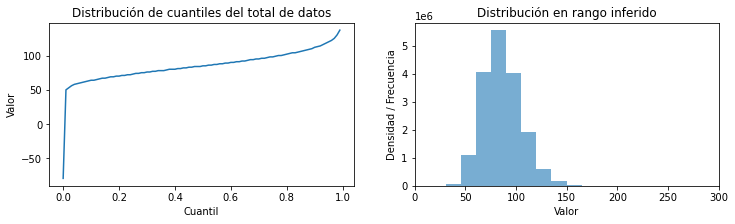

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :      17,565,063 | Unidad de medida inferida     :  Latidos por minuto (bpm)
 Mínimo           :          -79.00 | Rango                         :                  ]0, 300[
 Media            :           86.57 | N° Obs. totales (incluidas %) :      17,565,063 (99.972%)
 Mediana          :           85.00 | Excluidos por límite inferior :            4,763 (0.027%)
 Máximo           :       98,102.00 | Excluidos por límite superior :              165 (0.001%)
 Percentil 01     :           50.00 |
 Percentil 05     :           59.00 |
 Percentil 95     :          120.00 |
 Percentil 99     :          137.00 |


In [4]:
plot_results(var, 'Latidos por minuto (bpm)', 0 , 300, (0, 0))

De la tabla `vitalperiodic` hay 145979794 observaciones de ritmo cardiaco. Debido al volumen de observaciones no es posible analizarlo directamente en este notebook, por lo que se computó el mínimo (min), media (avg), mediana (median), máximo (max) y los percentiles 1, 5, 95 y 99 (p01, p05, p95 y p99, respectivamente) directamente desde PostgreSQL. La variable en esta tabla tiene una distribución similar a la encontrada en `nursecharting`, por lo que se infiere la misma unidad de medida y rango.

    eicu=# select count(*), min(heartrate), round(avg(heartrate), 2) as avg, percentile_disc(0.5) within group (order by heartrate) as median, max(heartrate), percentile_disc(0.01) within group (order by heartrate) as p01, percentile_disc(0.05) within group (order by heartrate) as p05, percentile_disc(0.95) within group (order by heartrate) as p95, percentile_disc(0.99) within group (order by heartrate) as p99 from vitalperiodic where heartrate is not null;
    
       count   | min |  avg  | median | max | p01 | p05 | p95 | p99 
    -----------+-----+-------+--------+-----+-----+-----+-----+-----
     145979794 |   0 | 85.83 |     84 | 300 |  50 |  59 | 118 | 133


## Respiratory rate

In [5]:
query = f'''select nursingchartvalue::numeric as var
    from nursecharting 
    where nursingchartcelltypevallabel = 'Respiratory Rate'
        and nursingchartcelltypevalname = 'Respiratory Rate'
    order by var'''
var = pd.read_sql(query, eicu)['var']

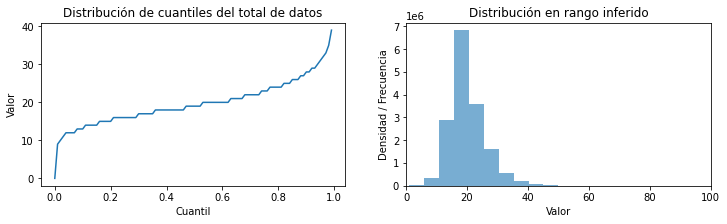

 Distribución                       | Inferencia                                                    
 -----------------------------------+---------------------------------------------------------------
 N° Observaciones :      16,180,404 | Unidad de medida inferida     : Respiraciones por minuto (rpm)
 Mínimo           :            0.00 | Rango                         :                       ]0, 100[
 Media            :           19.95 | N° Obs. totales (incluidas %) :           16,180,404 (99.715%)
 Mediana          :           19.00 | Excluidos por límite inferior :                44,417 (0.275%)
 Máximo           :        2,122.00 | Excluidos por límite superior :                 1,773 (0.011%)
 Percentil 01     :            9.00 |
 Percentil 05     :           12.00 |
 Percentil 95     :           31.00 |
 Percentil 99     :           39.00 |


In [6]:
plot_results(var, 'Respiraciones por minuto (rpm)', 0, 100, (0, 0))

De la tabla `vitalperiodic` hay 128501032 observaciones de ritmo respiratorio. Debido al volumen de observaciones no es posible analizarlo directamente en este notebook, por lo que se computó el mínimo (min), media (avg), mediana (median), máximo (max) y los percentiles 1, 5, 95 y 99 (p01, p05, p95 y p99, respectivamente) directamente desde PostgreSQL. La variable en esta tabla tiene una distribución similar a la encontrada en `nursecharting`, por lo que se infiere la misma unidad de medida y rango.

    eicu=# select count(*), min(respiration), round(avg(respiration), 2) as avg, percentile_disc(0.5) within group (order by respiration) as median, max(respiration), percentile_disc(0.01) within group (order by respiration) as p01, percentile_disc(0.05) within group (order by respiration) as p05, percentile_disc(0.95) within group (order by respiration) as p95, percentile_disc(0.99) within group (order by respiration) as p99 from vitalperiodic where respiration is not null;
    
       count   | min |  avg  | median |  max  | p01 | p05 | p95 | p99 
    -----------+-----+-------+--------+-------+-----+-----+-----+-----
     128501032 |   0 | 20.11 |     19 | 63012 |   2 |  11 |  32 |  40

## Temperature

In [7]:
query = f'''select nursingchartvalue::numeric as var
    from nursecharting 
    where (nursingchartcelltypevallabel = 'Temperature'
        and nursingchartcelltypevalname = 'Temperature (C)')
    union
    select temperature::numeric as var
    from vitalperiodic
    where temperature is not null
    order by var'''
var = pd.read_sql(query, eicu)['var']

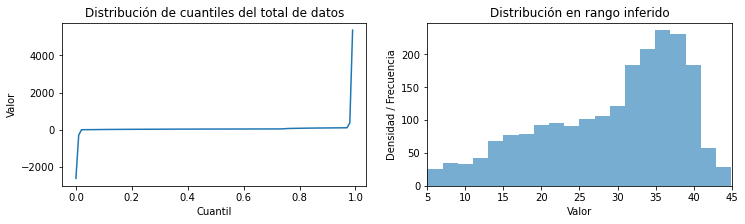

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :           3,112 | Unidad de medida inferida     :              Celsius (°C)
 Mínimo           :       -2,622.50 | Rango                         :                   [5, 45[
 Media            :          242.63 | N° Obs. totales (incluidas %) :           3,112 (67.256%)
 Mediana          :           34.79 | Excluidos por límite inferior :              219 (7.037%)
 Máximo           :       56,705.50 | Excluidos por límite superior :             800 (25.707%)
 Percentil 01     :         -293.12 |
 Percentil 05     :            2.42 |
 Percentil 95     :          101.27 |
 Percentil 99     :        5,362.43 |


In [8]:
plot_results(var, 'Celsius (°C)', 5, 45, (1, 0))

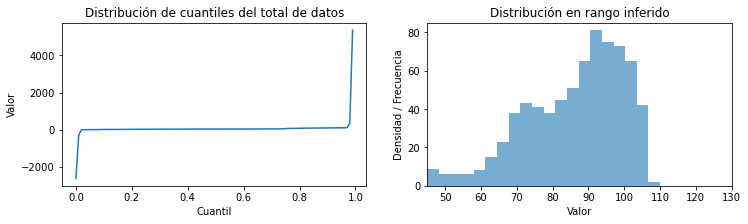

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :           3,112 | Unidad de medida inferida     :           Fahrenheit (°F)
 Mínimo           :       -2,622.50 | Rango                         :                 [45, 130[
 Media            :          242.63 | N° Obs. totales (incluidas %) :           3,112 (23.522%)
 Mediana          :           34.79 | Excluidos por límite inferior :           2,312 (74.293%)
 Máximo           :       56,705.50 | Excluidos por límite superior :               68 (2.185%)
 Percentil 01     :         -293.12 |
 Percentil 05     :            2.42 |
 Percentil 95     :          101.27 |
 Percentil 99     :        5,362.43 |


In [9]:
plot_results(var, 'Fahrenheit (°F)', 45, 130, (1, 0))

En este caso, se presenta una distribución bimodal (moda inferior: ~36, moda superior: ~90), por lo que podría tratarse de dos unidades de medida juntas. Para el conjunto de datos entre 5 y 45 se infiere `°C` como unidad de medida, y para valores entre 45 y 130 se infiere `°F`. Podría haber una porción de observaciones entre 40 y 45 que puedan tomarse como `°C` cuando en verdad son `°F`. Evaluar ajustar este límite.

De la tabla vitalperiodic hay 13203289 observaciones de temperatura. Debido al volumen de observaciones no es posible analizarlo directamente en este notebook, por lo que se computó el mínimo (min), media (avg), mediana (median), máximo (max) y los percentiles 1, 5, 95 y 99 (p01, p05, p95 y p99, respectivamente) directamente desde PostgreSQL. La variable en esta tabla tiene una distribución unimodal, a diferencia de la tabla anterior. La mayor parte de los datos de concentra en torno al 36, por lo que se infiere que sólo son datos en `°C`. Se sugiere descartar valores mayores a 45.

    eicu=# select count(*), min(temperature), round(avg(temperature), 2) as avg, percentile_disc(0.5) within group (order by temperature) as median, max(temperature), percentile_disc(0.01) within group (order by temperature) as p01, percentile_disc(0.05) within group (order by temperature) as p05, percentile_disc(0.95) within group (order by temperature) as p95, percentile_disc(0.99) within group (order by temperature) as p99 from vitalperiodic where temperature is not null;
      count   |    min     |  avg  | median  |   max    |   p01   |   p05   |   p95   |   p99   
    ----------+------------+-------+---------+----------+---------+---------+---------+---------
     13203289 | -2622.5000 | 39.01 | 37.3000 | 106.8000 | 33.0000 | 35.7000 | 38.8000 | 99.7000

## O2 Saturation

In [10]:
query = f'''select nursingchartvalue::numeric as var
    from nursecharting 
    where nursingchartcelltypevallabel = 'O2 Saturation'
        and nursingchartcelltypevalname = 'O2 Saturation'
    order by var'''
var = pd.read_sql(query, eicu)['var']

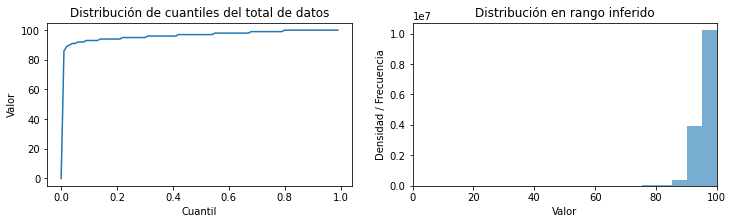

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :      14,661,045 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :            0.00 | Rango                         :                  ]0, 100]
 Media            :           96.59 | N° Obs. totales (incluidas %) :      14,661,045 (99.995%)
 Mediana          :           97.00 | Excluidos por límite inferior :              636 (0.004%)
 Máximo           :       95,121.00 | Excluidos por límite superior :              125 (0.001%)
 Percentil 01     :           86.00 |
 Percentil 05     :           91.00 |
 Percentil 95     :          100.00 |
 Percentil 99     :          100.00 |


In [11]:
plot_results(var, 'Puntos porcentuales (%)', 0, 100, (0, 1))

De la tabla vitalperiodic hay 132908266 observaciones de saturación de oxígeno. Debido al volumen de observaciones no es posible analizarlo directamente en este notebook, por lo que se computó el mínimo (min), media (avg), mediana (median), máximo (max) y los percentiles 1, 5, 95 y 99 (p01, p05, p95 y p99, respectivamente) directamente desde PostgreSQL. La variable en esta tabla tiene una distribución similar a la encontrada en nursecharting, por lo que se infiere la misma unidad de medida y rango.

    eicu=# select count(*), min(sao2), round(avg(sao2), 2) as avg, percentile_disc(0.5) within group (order by sao2) as median, max(sao2),     percentile_disc(0.01) within group (order by sao2) as p01, percentile_disc(0.05) within group (order by sao2) as p05, percentile_disc(0.95) within group (order by sao2) as p95, percentile_disc(0.99) within group (order by sao2) as p99 from vitalperiodic where sao2 is not null;
    
       count   | min |  avg  | median | max | p01 | p05 | p95 | p99 
    -----------+-----+-------+--------+-----+-----+-----+-----+-----
     132908266 |   0 | 96.68 |     97 | 239 |  86 |  91 | 100 | 100


## SBP

In [12]:
query = f'''select nursingchartvalue::numeric as var
    from nursecharting 
    where nursingchartcelltypevallabel = 'Non-Invasive BP'
        and nursingchartcelltypevalname = 'Non-Invasive BP Systolic'
    order by var'''
var = pd.read_sql(query, eicu)['var']

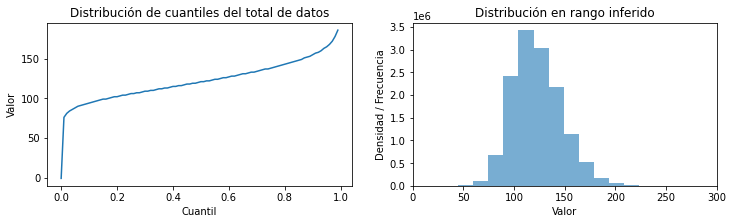

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :      13,759,074 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :           -1.00 | Rango                         :                      ]0, 300[
 Media            :          122.97 | N° Obs. totales (incluidas %) :          13,759,074 (99.997%)
 Mediana          :          121.00 | Excluidos por límite inferior :                  315 (0.002%)
 Máximo           :      175,102.00 | Excluidos por límite superior :                   90 (0.001%)
 Percentil 01     :           76.00 |
 Percentil 05     :           88.00 |
 Percentil 95     :          165.00 |
 Percentil 99     :          186.00 |


In [13]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 300, (0, 0))

De la tabla vitalperiodic hay 27834960 observaciones de presión sistólica. Debido al volumen de observaciones no es posible analizarlo directamente en este notebook, por lo que se computó el mínimo (min), media (avg), mediana (median), máximo (max) y los percentiles 1, 5, 95 y 99 (p01, p05, p95 y p99, respectivamente) directamente desde PostgreSQL. La variable en esta tabla tiene una distribución similar a la encontrada en nursecharting, por lo que se infiere la misma unidad de medida y rango.

    eicu=# select count(*), min(systemicsystolic), round(avg(systemicsystolic), 2) as avg, percentile_disc(0.5) within group (order by systemicsystolic) as median, max(systemicsystolic), percentile_disc(0.01) within group (order by systemicsystolic) as p01, percentile_disc(0.05) within group (order by systemicsystolic) as p05, percentile_disc(0.95) within group (order by systemicsystolic) as p95, percentile_disc(0.99) within group (order by systemicsystolic) as p99 from vitalperiodic where systemicsystolic is not null;
    
      count   | min |  avg   | median | max | p01 | p05 | p95 | p99 
    ----------+-----+--------+--------+-----+-----+-----+-----+-----
     27834960 | -96 | 123.04 |    120 | 398 |  71 |  87 | 167 | 190


## DBP

In [14]:
query = f'''select nursingchartvalue::numeric as var
    from nursecharting 
    where nursingchartcelltypevallabel = 'Non-Invasive BP'
        and nursingchartcelltypevalname = 'Non-Invasive BP Diastolic'
    order by var'''
var = pd.read_sql(query, eicu)['var']

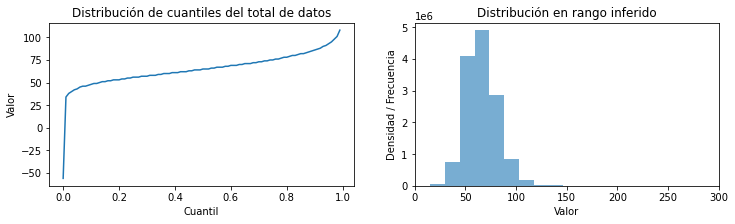

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :      13,759,225 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :          -56.00 | Rango                         :                      ]0, 300[
 Media            :           66.08 | N° Obs. totales (incluidas %) :          13,759,225 (99.961%)
 Mediana          :           65.00 | Excluidos por límite inferior :                5,262 (0.038%)
 Máximo           :        6,481.00 | Excluidos por límite superior :                  146 (0.001%)
 Percentil 01     :           34.00 |
 Percentil 05     :           43.00 |
 Percentil 95     :           93.00 |
 Percentil 99     :          108.00 |


In [15]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 300, (0, 0))

De la tabla vitalperiodic hay 27833847 observaciones de presión diastólica. Debido al volumen de observaciones no es posible analizarlo directamente en este notebook, por lo que se computó el mínimo (min), media (avg), mediana (median), máximo (max) y los percentiles 1, 5, 95 y 99 (p01, p05, p95 y p99, respectivamente) directamente desde PostgreSQL. La variable en esta tabla tiene una distribución similar a la encontrada en nursecharting, por lo que se infiere la misma unidad de medida y rango.

    eicu=# select count(*), min(systemicdiastolic), round(avg(systemicdiastolic), 2) as avg, percentile_disc(0.5) within group (order by systemicdiastolic) as median, max(systemicdiastolic), percentile_disc(0.01) within group (order by systemicdiastolic) as p01, percentile_disc(0.05) within group (order by systemicdiastolic) as p05, percentile_disc(0.95) within group (order by systemicdiastolic) as p95, percentile_disc(0.99) within group (order by systemicdiastolic) as p99 from vitalperiodic where systemicdiastolic is not null;

      count   | min |  avg  | median | max | p01 | p05 | p95 | p99 
    ----------+-----+-------+--------+-----+-----+-----+-----+-----
     27833847 | -96 | 59.64 |     58 | 395 |  33 |  40 |  84 | 102


## MAP

In [16]:
query = f'''select nursingchartvalue::numeric as var
    from nursecharting 
    where (nursingchartcelltypevallabel = 'Invasive BP'
        and nursingchartcelltypevalname = 'Invasive BP Mean')
        or (nursingchartcelltypevallabel = 'MAP (mmHg)'
        and nursingchartcelltypevalname = 'Value')
        or (nursingchartcelltypevallabel = 'Arterial Line MAP (mmHg)'
        and nursingchartcelltypevalname = 'Value')
        or (nursingchartcelltypevallabel = 'PA'
        and nursingchartcelltypevalname = 'PA Mean')
    order by var'''
var = pd.read_sql(query, eicu)['var']

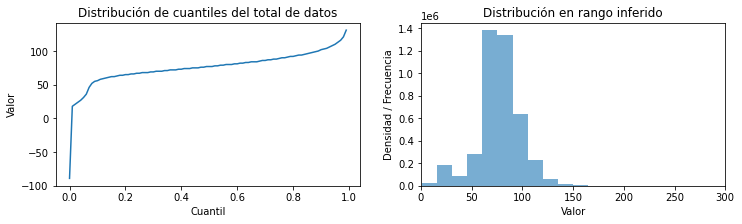

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :       4,255,444 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :          -89.00 | Rango                         :                      ]0, 300[
 Media            :           77.41 | N° Obs. totales (incluidas %) :           4,255,444 (99.892%)
 Mediana          :           77.00 | Excluidos por límite inferior :                2,394 (0.056%)
 Máximo           :      124,124.00 | Excluidos por límite superior :                2,187 (0.051%)
 Percentil 01     :           18.00 |
 Percentil 05     :           31.00 |
 Percentil 95     :          110.00 |
 Percentil 99     :          131.00 |


In [17]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 300, (0, 0))

De la tabla vitalperiodic hay 4150132 observaciones de presión arterial media. Debido al volumen de observaciones no es posible analizarlo directamente en este notebook, por lo que se computó el mínimo (min), media (avg), mediana (median), máximo (max) y los percentiles 1, 5, 95 y 99 (p01, p05, p95 y p99, respectivamente) directamente desde PostgreSQL. La variable en esta tabla tiene una distribución similar a la encontrada en nursecharting, por lo que se infiere la misma unidad de medida y rango.

      count  | min |  avg  | median | max | p01 | p05 | p95 | p99 
    ---------+-----+-------+--------+-----+-----+-----+-----+-----
     4150132 | -94 | 27.19 |     26 | 385 |  10 |  15 |  43 |  55

## CVP

In [33]:
query = f'''select nursingchartvalue::numeric as var
    from nursecharting 
    where (nursingchartcelltypevallabel = 'CVP'
        and nursingchartcelltypevalname = 'CVP')
        or (nursingchartcelltypevallabel = 'CVP (mmHg)'
        and nursingchartcelltypevalname = 'Value')
    order by var'''
var = pd.read_sql(query, eicu)['var']

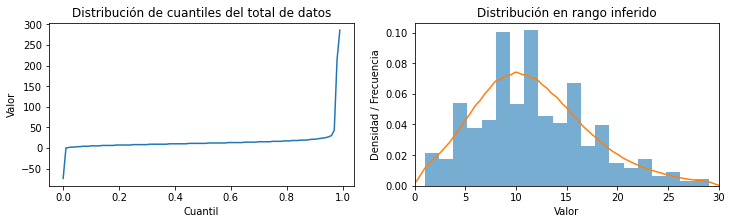

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :       1,268,758 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :          -74.00 | Rango                         :                       ]0, 30[
 Media            :           18.30 | N° Obs. totales (incluidas %) :           1,268,758 (94.504%)
 Mediana          :           11.00 | Excluidos por límite inferior :               16,689 (1.315%)
 Máximo           :        3,817.00 | Excluidos por límite superior :               53,046 (4.181%)
 Percentil 01     :            0.00 |
 Percentil 05     :            3.00 |
 Percentil 95     :           27.00 |
 Percentil 99     :          286.00 |


In [34]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 30, (0, 0), density=0.1)

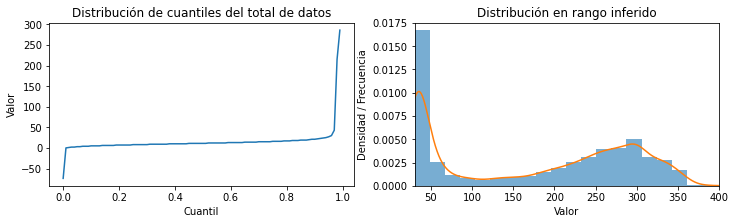

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :       1,268,758 | Unidad de medida inferida     :                       N/A
 Mínimo           :          -74.00 | Rango                         :                 [30, 400[
 Media            :           18.30 | N° Obs. totales (incluidas %) :        1,268,758 (4.180%)
 Mediana          :           11.00 | Excluidos por límite inferior :       1,215,712 (95.819%)
 Máximo           :        3,817.00 | Excluidos por límite superior :                7 (0.001%)
 Percentil 01     :            0.00 |
 Percentil 05     :            3.00 |
 Percentil 95     :           27.00 |
 Percentil 99     :          286.00 |


In [35]:
plot_results(var, 'N/A', 30, 400, (1, 0), density=0.1)

En este caso, se presenta una distribución bimodal (moda inferior: ~10, moda superior: ~280), por lo que podría tratarse de dos unidades de medida juntas. esta distribución se presenta tanto para `nursingchartcelltypevallabel = 'CVP'` como para `nursingchartcelltypevallabel = 'CVP (mmHg)'`. Para el conjunto de datos entre 0 y 30 se infiere `mmHg` como unidad de medida, aunque podría tratarse también de `cmH2O` (`1 mmHg = 1.36 cmH2O`). Valores mayores a 30 representan el 4.180% de los datos y se sugiere descartarlos.

De la tabla vitalperiodic hay 19157758 observaciones de presión venosa central. Debido al volumen de observaciones no es posible analizarlo directamente en este notebook, por lo que se computó el mínimo (min), media (avg), mediana (median), máximo (max) y los percentiles 1, 5, 95 y 99 (p01, p05, p95 y p99, respectivamente) directamente desde PostgreSQL. La variable en esta tabla tiene una distribución similar a la encontrada en nursecharting, por lo que se infiere la misma unidad de medida y rango.

    eicu=# select count(*), min(cvp), round(avg(cvp), 2) as avg, percentile_disc(0.5) within group (order by cvp) as median, max(cvp), percentile_disc(0.01) within group (order by cvp) as p01, percentile_disc(0.05) within group (order by cvp) as p05, percentile_disc(0.95) within group (order by cvp) as p95, percentile_disc(0.99) within group (order by cvp) as p99 from vitalperiodic where cvp is not null;

      count   | min  |  avg  | median | max | p01 | p05 | p95 | p99 
    ----------+------+-------+--------+-----+-----+-----+-----+-----
     19157758 | -104 | 37.89 |     12 | 400 |  -4 |   1 | 275 | 333



## FiO2

In [124]:
query = f'''select labresult as var from lab where labname = 'FiO2' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

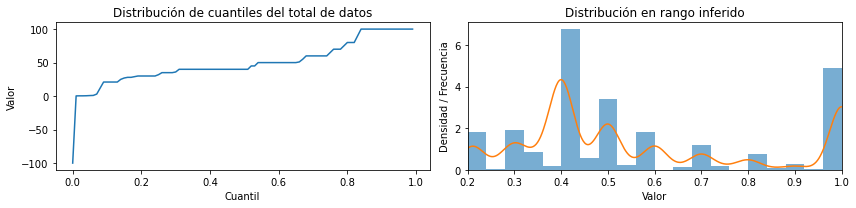

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         343,331 | Unidad de medida inferida     :            Fracción (N/A)
 Mínimo           :         -100.00 | Rango                         :                  [0.2, 1]
 Media            :           55.16 | N° Obs. incluidas             :           20,514 (5.975%)
 Mediana          :           40.00 | Excluidos por límite inferior :            1,003 (0.292%)
 Máximo           :       10,000.00 | Excluidos por límite superior :         321,814 (93.733%)
 Percentil 01     :            0.30 |
 Percentil 05     :            0.80 |
 Percentil 95     :          100.00 |
 Percentil 99     :          100.00 |


In [125]:
plot_results(var, 'Fracción (N/A)', 0.20, 1, (1, 1), density=0.1)

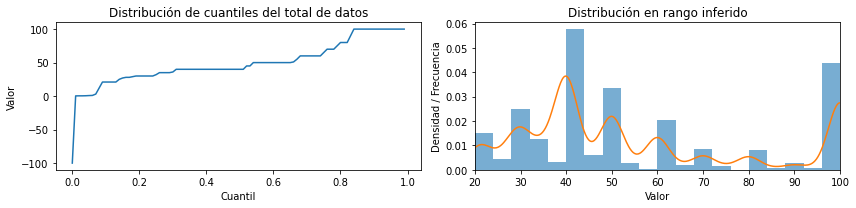

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         343,331 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :         -100.00 | Rango                         :                 [20, 100]
 Media            :           55.16 | N° Obs. incluidas             :         314,847 (91.704%)
 Mediana          :           40.00 | Excluidos por límite inferior :           28,098 (8.184%)
 Máximo           :       10,000.00 | Excluidos por límite superior :              386 (0.112%)
 Percentil 01     :            0.30 |
 Percentil 05     :            0.80 |
 Percentil 95     :          100.00 |
 Percentil 99     :          100.00 |


In [126]:
plot_results(var, 'Puntos porcentuales (%)', 20, 100, (1, 1), density=0.1)

En este caso, se presenta una distribución multimodal. Los valores entre 0.20 y 1 se asumen como fracciones, y entre 20 y 100 como porcentajes. Se sugiere descartar valores menores a 0.20 o entre 1 y 20.

## paO2

In [127]:
query = f'''select labresult as var from lab where labname = 'paO2' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

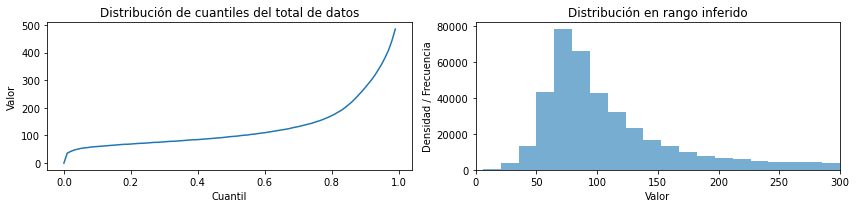

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :         418,109 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :            0.00 | Rango                         :                      ]0, 300[
 Media            :          132.08 | N° Obs. incluidas             :             383,596 (91.745%)
 Mediana          :           96.00 | Excluidos por límite inferior :                   13 (0.003%)
 Máximo           :        1,143.80 | Excluidos por límite superior :               34,500 (8.251%)
 Percentil 01     :           36.00 |
 Percentil 05     :           53.00 |
 Percentil 95     :          359.26 |
 Percentil 99     :          485.00 |


In [128]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 300, (0, 0))

## paCO2

In [129]:
query = f'''select labresult as var from lab where labname = 'paCO2' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

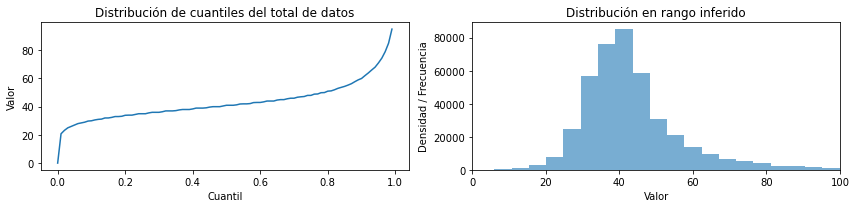

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :         414,622 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :            0.00 | Rango                         :                      ]0, 100[
 Media            :           43.51 | N° Obs. incluidas             :             411,622 (99.276%)
 Mediana          :           41.00 | Excluidos por límite inferior :                   25 (0.006%)
 Máximo           :          240.00 | Excluidos por límite superior :                2,975 (0.718%)
 Percentil 01     :           20.80 |
 Percentil 05     :           27.00 |
 Percentil 95     :           71.00 |
 Percentil 99     :           95.00 |


In [130]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 100, (0, 0))

## Bilirubin

In [131]:
query = f'''select labresult as var from lab where labname = 'total bilirubin' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

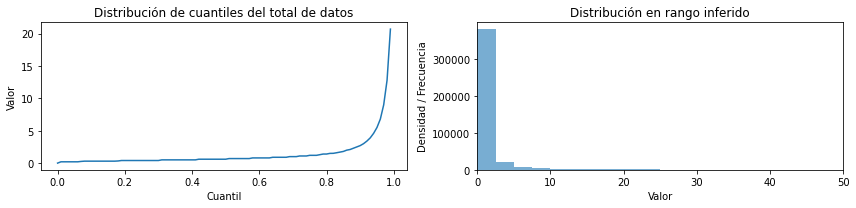

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :         425,009 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.00 | Rango                         :                          ]0, 50[
 Media            :            1.56 | N° Obs. incluidas             :                424,936 (99.983%)
 Mediana          :            0.60 | Excluidos por límite inferior :                       9 (0.002%)
 Máximo           :           99.00 | Excluidos por límite superior :                      64 (0.015%)
 Percentil 01     :            0.20 |
 Percentil 05     :            0.20 |
 Percentil 95     :            5.50 |
 Percentil 99     :           20.70 |


In [132]:
plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 50, (0, 0))

## Creatinine

In [133]:
query = f'''select labresult as var from lab where labname = 'creatinine' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

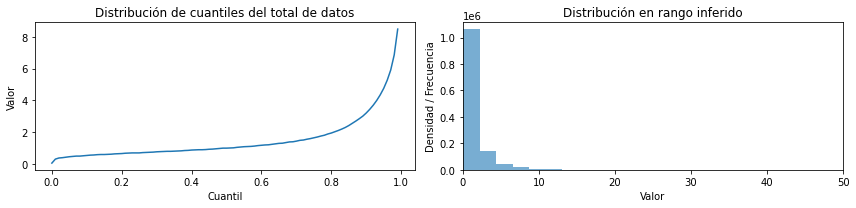

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :       1,275,796 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.06 | Rango                         :                          ]0, 50[
 Media            :            1.55 | N° Obs. incluidas             :             1,275,795 (100.000%)
 Mediana          :            1.00 | Excluidos por límite inferior :                       0 (0.000%)
 Máximo           :          129.00 | Excluidos por límite superior :                       1 (0.000%)
 Percentil 01     :            0.31 |
 Percentil 05     :            0.46 |
 Percentil 95     :            4.76 |
 Percentil 99     :            8.48 |


In [134]:
plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 50, (0, 0))

## BUN

In [135]:
query = f'''select labresult as var from lab where labname = 'BUN' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

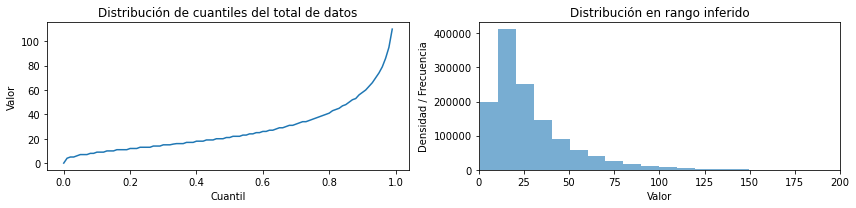

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :       1,268,397 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.00 | Rango                         :                         ]0, 200[
 Media            :           28.33 | N° Obs. incluidas             :              1,268,071 (99.974%)
 Mediana          :           21.00 | Excluidos por límite inferior :                       4 (0.000%)
 Máximo           :       28,131.00 | Excluidos por límite superior :                     322 (0.025%)
 Percentil 01     :            4.00 |
 Percentil 05     :            7.00 |
 Percentil 95     :           74.00 |
 Percentil 99     :          110.00 |


In [136]:

plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 200, (0, 0))

## Hematocrit

In [137]:
query = f'''select labresult as var from lab where labname = 'Hct' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

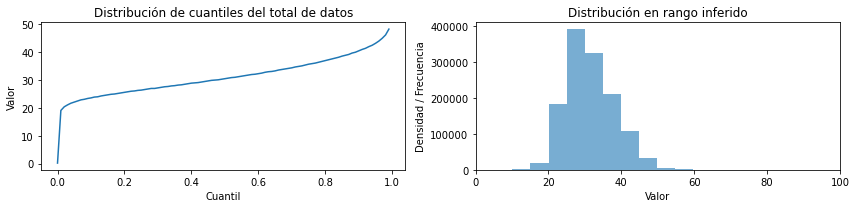

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :       1,278,917 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :            0.20 | Rango                         :                  ]0, 100[
 Media            :           31.35 | N° Obs. incluidas             :      1,278,917 (100.000%)
 Mediana          :           30.50 | Excluidos por límite inferior :                0 (0.000%)
 Máximo           :           99.40 | Excluidos por límite superior :                0 (0.000%)
 Percentil 01     :           19.10 |
 Percentil 05     :           22.10 |
 Percentil 95     :           43.20 |
 Percentil 99     :           48.30 |


In [139]:
plot_results(var, 'Puntos porcentuales (%)', 0, 100, (0, 0))

## HCO3

In [140]:
query = f'''select labresult as var from lab where labname in ('bicarbonate','HCO3') and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

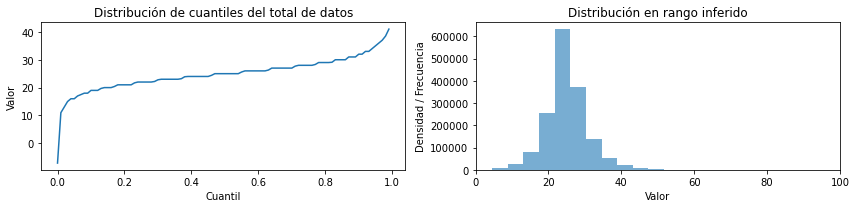

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :       1,588,231 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :           -7.10 | Rango                         :                           ]0, 100[
 Media            :           25.13 | N° Obs. incluidas             :                1,588,200 (99.998%)
 Mediana          :           25.00 | Excluidos por límite inferior :                        26 (0.002%)
 Máximo           :          332.00 | Excluidos por límite superior :                         5 (0.000%)
 Percentil 01     :           11.00 |
 Percentil 05     :           16.00 |
 Percentil 95     :           35.00 |
 Percentil 99     :           41.00 |


In [144]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 0, 100, (0, 0))

## pH

In [145]:
query = f'''select labresult as var from lab where labname = 'pH' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

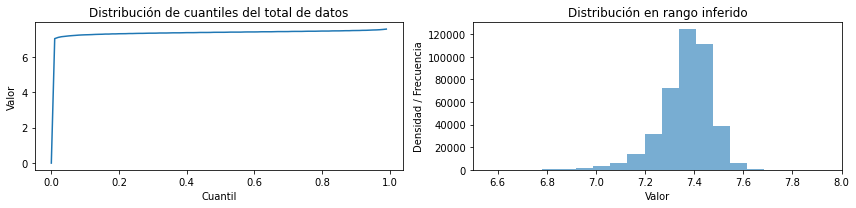

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         412,000 | Unidad de medida inferida     :                       N/A
 Mínimo           :            0.00 | Rango                         :                  ]6.5, 8[
 Media            :            7.39 | N° Obs. incluidas             :         411,926 (99.982%)
 Mediana          :            7.38 | Excluidos por límite inferior :               61 (0.015%)
 Máximo           :        7,410.00 | Excluidos por límite superior :               13 (0.003%)
 Percentil 01     :            7.02 |
 Percentil 05     :            7.17 |
 Percentil 95     :            7.51 |
 Percentil 99     :            7.56 |


In [148]:
plot_results(var, 'N/A', 6.5, 8, (0, 0))

## Platelets

In [161]:
query = f'''select labresult as var from lab where labname = 'platelets x 1000' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

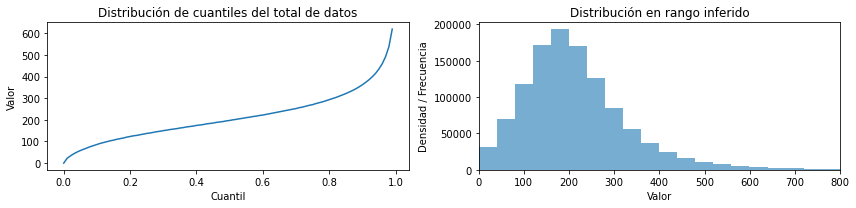

 Distribución                       | Inferencia                                                          
 -----------------------------------+---------------------------------------------------------------------
 N° Observaciones :       1,139,619 | Unidad de medida inferida     : Miles por milímetro cuadrado (k/mm2)
 Mínimo           :            0.00 | Rango                         :                             ]0, 800[
 Media            :          215.75 | N° Obs. incluidas             :                  1,136,763 (99.749%)
 Mediana          :          197.00 | Excluidos por límite inferior :                           7 (0.001%)
 Máximo           :        3,092.00 | Excluidos por límite superior :                       2,849 (0.250%)
 Percentil 01     :           22.00 |
 Percentil 05     :           58.00 |
 Percentil 95     :          435.00 |
 Percentil 99     :          619.00 |


In [162]:
plot_results(var, 'Miles por milímetro cuadrado (10^3/mm2)', 0, 800, (0, 0))

## Potassium

In [152]:
query = f'''select labresult as var from lab where labname = 'potassium' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

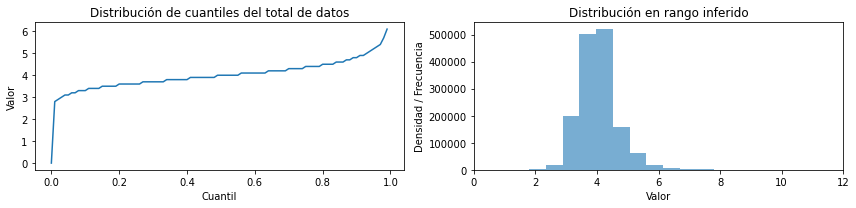

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :       1,492,987 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :            0.00 | Rango                         :                            ]0, 12[
 Media            :            4.04 | N° Obs. incluidas             :                1,492,976 (99.999%)
 Mediana          :            4.00 | Excluidos por límite inferior :                         1 (0.000%)
 Máximo           :           17.00 | Excluidos por límite superior :                        10 (0.001%)
 Percentil 01     :            2.80 |
 Percentil 05     :            3.10 |
 Percentil 95     :            5.20 |
 Percentil 99     :            6.10 |


In [154]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 0, 12, (0, 0))

## Sodium

In [155]:
query = f'''select labresult as var from lab where labname = 'sodium' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

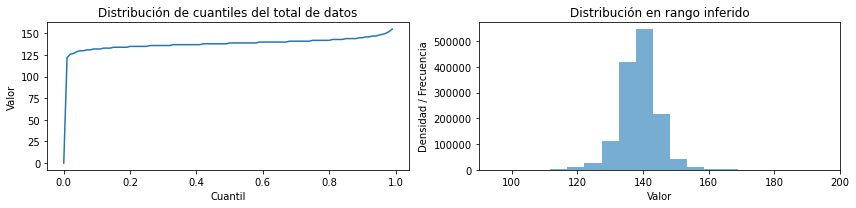

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :       1,393,097 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :            0.00 | Rango                         :                          ]90, 200[
 Media            :          138.57 | N° Obs. incluidas             :               1,393,093 (100.000%)
 Mediana          :          139.00 | Excluidos por límite inferior :                         3 (0.000%)
 Máximo           :          224.00 | Excluidos por límite superior :                         1 (0.000%)
 Percentil 01     :          122.00 |
 Percentil 05     :          130.00 |
 Percentil 95     :          148.00 |
 Percentil 99     :          155.00 |


In [159]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 90, 200, (0, 0))

## WBC

In [160]:
query = f'''select labresult as var from lab where labname = 'WBC x 1000' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

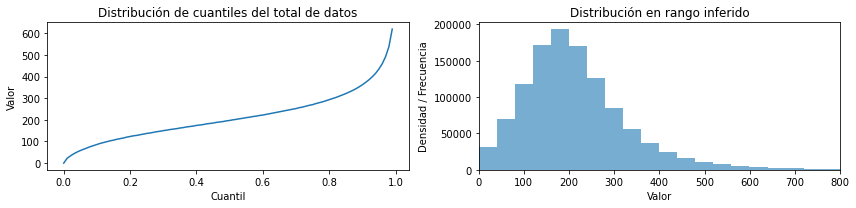

 Distribución                       | Inferencia                                                          
 -----------------------------------+---------------------------------------------------------------------
 N° Observaciones :       1,139,619 | Unidad de medida inferida     : Miles por milímetro cuadrado (k/mm2)
 Mínimo           :            0.00 | Rango                         :                             ]0, 800[
 Media            :          215.75 | N° Obs. incluidas             :                  1,136,763 (99.749%)
 Mediana          :          197.00 | Excluidos por límite inferior :                           7 (0.001%)
 Máximo           :        3,092.00 | Excluidos por límite superior :                       2,849 (0.250%)
 Percentil 01     :           22.00 |
 Percentil 05     :           58.00 |
 Percentil 95     :          435.00 |
 Percentil 99     :          619.00 |


In [163]:
plot_results(var, 'Miles por micrilitro (10^3/mL)', 0, 800, (0, 0))

## Lymphocytes

In [164]:
query = f'''select labresult as var from lab where labname = '-lymphs' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

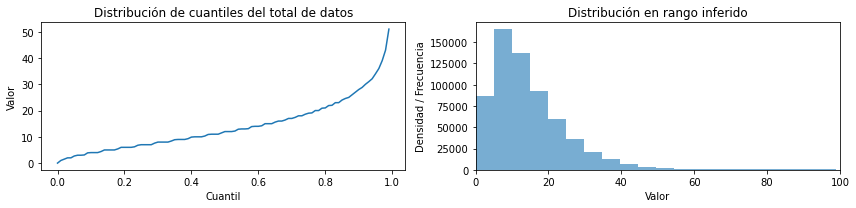

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         630,818 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :            0.00 | Rango                         :                  [0, 100[
 Media            :           15.89 | N° Obs. incluidas             :         630,543 (99.956%)
 Mediana          :           12.00 | Excluidos por límite inferior :                0 (0.000%)
 Máximo           :      999,999.00 | Excluidos por límite superior :              275 (0.044%)
 Percentil 01     :            1.00 |
 Percentil 05     :            2.70 |
 Percentil 95     :           34.00 |
 Percentil 99     :           51.00 |


In [167]:
plot_results(var, 'Puntos porcentuales (%)', 0, 100, (1, 0))

## Neutrophils

In [168]:
query = f'''select labresult as var from lab where labname = '-polys' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

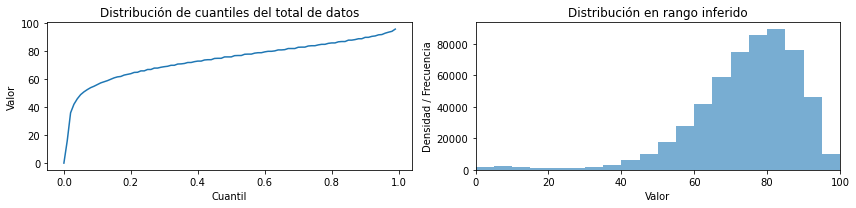

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         559,185 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :            0.00 | Rango                         :                  [0, 100]
 Media            :           73.97 | N° Obs. incluidas             :        559,185 (100.000%)
 Mediana          :           76.00 | Excluidos por límite inferior :                0 (0.000%)
 Máximo           :          100.00 | Excluidos por límite superior :                0 (0.000%)
 Percentil 01     :           16.00 |
 Percentil 05     :           49.00 |
 Percentil 95     :           92.00 |
 Percentil 99     :           95.90 |


In [170]:
plot_results(var, 'Puntos porcentuales (%)', 0, 100, (1, 1))

## AST

In [171]:
query = f'''select labresult as var from lab where labname = 'AST (SGOT)' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

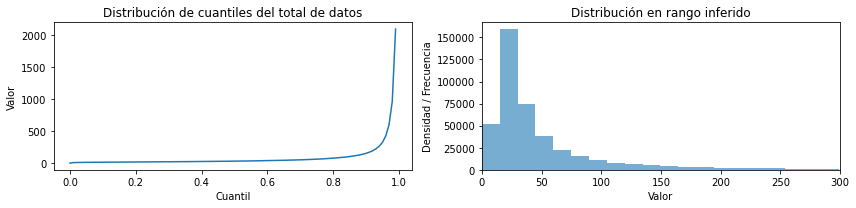

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         436,800 | Unidad de medida inferida     :  Unidades por litro (U/L)
 Mínimo           :            0.00 | Rango                         :                  [0, 300[
 Media            :          129.93 | N° Obs. incluidas             :         413,386 (94.640%)
 Mediana          :           31.00 | Excluidos por límite inferior :                0 (0.000%)
 Máximo           :       93,400.00 | Excluidos por límite superior :           23,414 (5.360%)
 Percentil 01     :            8.00 |
 Percentil 05     :           12.00 |
 Percentil 95     :          324.00 |
 Percentil 99     :        2,096.00 |


In [176]:
plot_results(var, 'Unidades por litro (U/L)', 0, 300, (1, 0))

## ALT

In [195]:
query = f'''select labresult as var from lab where labname = 'ALT (SGPT)' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

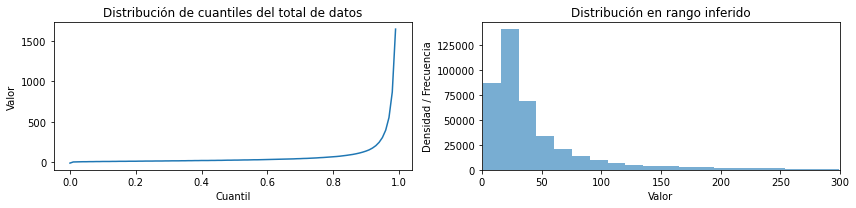

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         430,929 | Unidad de medida inferida     :  Unidades por litro (U/L)
 Mínimo           :           -8.00 | Rango                         :                  ]0, 300[
 Media            :          101.11 | N° Obs. incluidas             :         408,918 (94.892%)
 Mediana          :           29.00 | Excluidos por límite inferior :                2 (0.000%)
 Máximo           :       18,200.00 | Excluidos por límite superior :           22,009 (5.107%)
 Percentil 01     :            6.00 |
 Percentil 05     :            9.00 |
 Percentil 95     :          307.00 |
 Percentil 99     :        1,644.00 |


In [205]:
plot_results(var, 'Unidades por litro (U/L)', 0, 300, (0, 0))

## Alkaline Phospatase

In [189]:
query = f'''select labresult as var from lab where labname = 'alkaline phos.' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

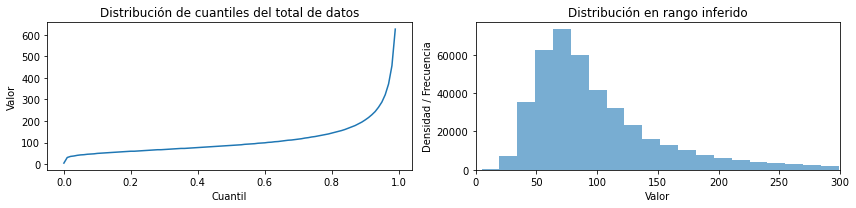

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         429,878 | Unidad de medida inferida     :  Unidades por litro (U/L)
 Mínimo           :            5.00 | Rango                         :                  ]0, 300[
 Media            :          118.84 | N° Obs. incluidas             :         409,978 (95.371%)
 Mediana          :           87.00 | Excluidos por límite inferior :                0 (0.000%)
 Máximo           :        7,629.00 | Excluidos por límite superior :           19,900 (4.629%)
 Percentil 01     :           31.00 |
 Percentil 05     :           43.00 |
 Percentil 95     :          288.00 |
 Percentil 99     :          626.00 |


In [192]:
plot_results(var, 'Unidades por litro (U/L)', 0, 300, (0, 0))

## Albumin

In [186]:
query = f'''select labresult as var from lab where labname = 'albumin' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

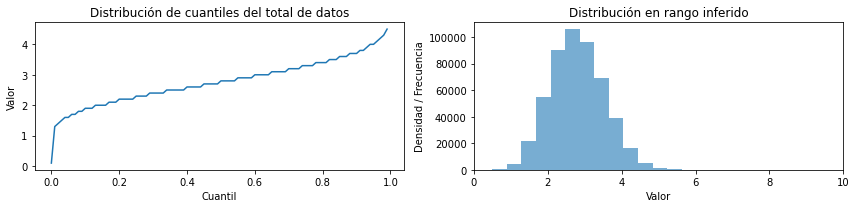

 Distribución                       | Inferencia                                                 
 -----------------------------------+------------------------------------------------------------
 N° Observaciones :         505,664 | Unidad de medida inferida     : Gramos por decilitro (g/dL)
 Mínimo           :            0.10 | Rango                         :                     [0, 10[
 Media            :            2.79 | N° Obs. incluidas             :           505,661 (99.999%)
 Mediana          :            2.80 | Excluidos por límite inferior :                  0 (0.000%)
 Máximo           :          154.00 | Excluidos por límite superior :                  3 (0.001%)
 Percentil 01     :            1.30 |
 Percentil 05     :            1.60 |
 Percentil 95     :            4.00 |
 Percentil 99     :            4.50 |


In [188]:
plot_results(var, 'Gramos por decilitro (g/dL)', 0, 10, (1, 0))

## Glucose

In [177]:
query = f'''select labresult as var from lab where labname in ('bedside glucose', 'glucose') and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

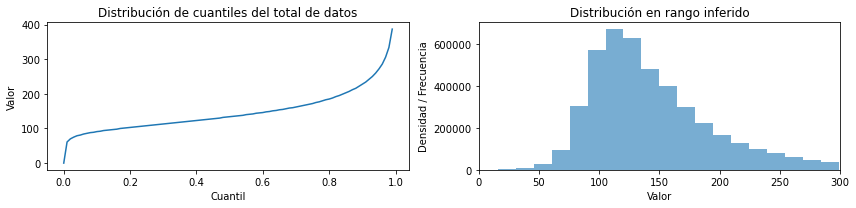

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :       4,488,463 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.00 | Rango                         :                         ]0, 300[
 Media            :          149.75 | N° Obs. incluidas             :              4,340,813 (96.710%)
 Mediana          :          134.00 | Excluidos por límite inferior :                       2 (0.000%)
 Máximo           :        2,827.00 | Excluidos por límite superior :                 147,648 (3.290%)
 Percentil 01     :           61.00 |
 Percentil 05     :           81.00 |
 Percentil 95     :          272.00 |
 Percentil 99     :          387.00 |


In [180]:
plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 300, (0, 0))

## Chloride

In [181]:
query = f'''select labresult as var from lab where labname = 'chloride' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

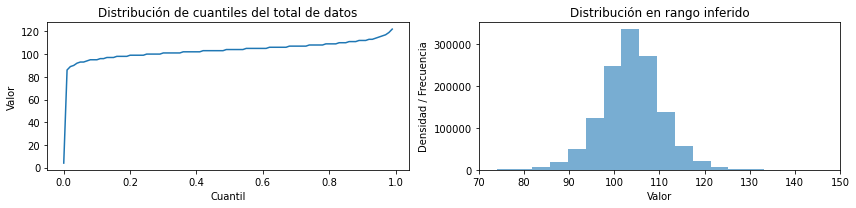

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :       1,283,689 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :            4.00 | Rango                         :                          [70, 150[
 Media            :          103.76 | N° Obs. incluidas             :                1,283,165 (99.959%)
 Mediana          :          104.00 | Excluidos por límite inferior :                       462 (0.036%)
 Máximo           :          170.70 | Excluidos por límite superior :                        62 (0.005%)
 Percentil 01     :           86.00 |
 Percentil 05     :           93.00 |
 Percentil 95     :          115.00 |
 Percentil 99     :          122.00 |


In [185]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 70, 150, (1, 0))

## Base Excess

In [206]:
query = f'''select labresult as var from lab where labname = 'Base Excess' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

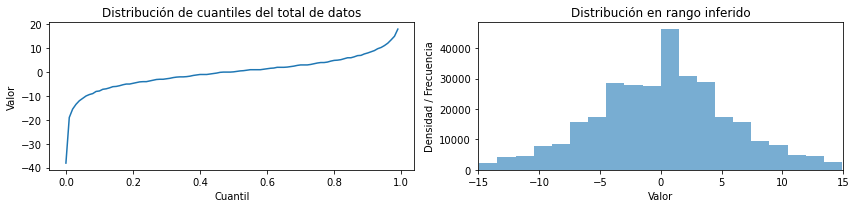

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :         328,016 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :          -38.10 | Rango                         :                          ]-15, 15[
 Media            :            0.08 | N° Obs. incluidas             :                  313,100 (95.453%)
 Mediana          :            0.10 | Excluidos por límite inferior :                     7,603 (2.318%)
 Máximo           :          158.00 | Excluidos por límite superior :                     7,313 (2.229%)
 Percentil 01     :          -19.00 |
 Percentil 05     :          -11.00 |
 Percentil 95     :           11.10 |
 Percentil 99     :           18.00 |


In [209]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', -15, 15, (0, 0))

## PTT

In [210]:
query = f'''select labresult as var from lab where labname = 'PTT' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

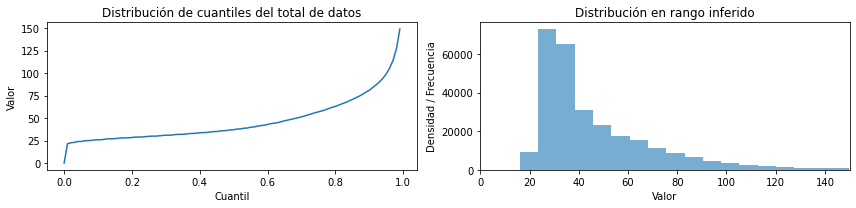

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         280,868 | Unidad de medida inferida     :              Segundos (s)
 Mínimo           :            0.00 | Rango                         :                  ]0, 150[
 Media            :           47.25 | N° Obs. incluidas             :         278,121 (99.022%)
 Mediana          :           37.10 | Excluidos por límite inferior :                1 (0.000%)
 Máximo           :          324.50 | Excluidos por límite superior :            2,746 (0.978%)
 Percentil 01     :           21.50 |
 Percentil 05     :           24.00 |
 Percentil 95     :           99.30 |
 Percentil 99     :          149.00 |


In [212]:
plot_results(var, 'Segundos (s)', 0, 150, (0, 0))

## BNP

In [214]:
query = f'''select labresult as var from lab where labname = 'BNP' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

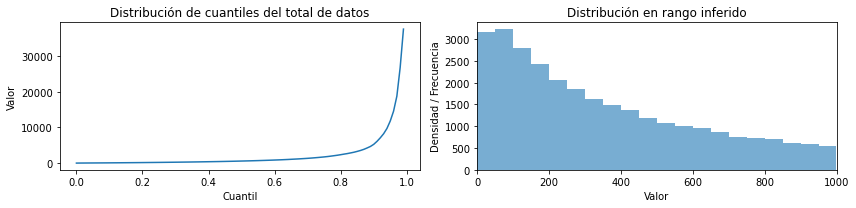

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :          45,701 | Unidad de medida inferida     : Picogramos por mililitro (pg/mL)
 Mínimo           :            1.00 | Rango                         :                        ]0, 1000[
 Media            :        2,678.81 | N° Obs. incluidas             :                 29,057 (63.581%)
 Mediana          :          579.00 | Excluidos por límite inferior :                       0 (0.000%)
 Máximo           :      193,730.00 | Excluidos por límite superior :                 16,644 (36.419%)
 Percentil 01     :           14.00 |
 Percentil 05     :           39.00 |
 Percentil 95     :       11,810.00 |
 Percentil 99     :       37,613.00 |


In [218]:
plot_results(var, 'Picogramos por mililitro (pg/mL)', 0, 1000, (0, 0))

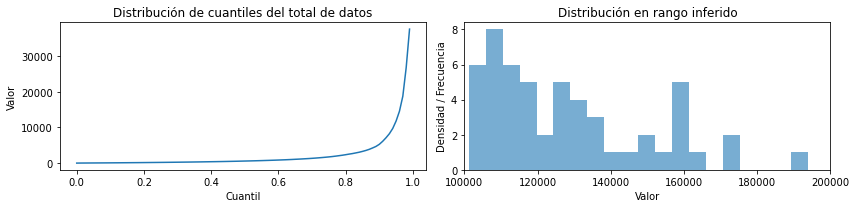

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :          45,701 | Unidad de medida inferida     : Picogramos por mililitro (pg/mL)
 Mínimo           :            1.00 | Rango                         :                 ]100000, 200000[
 Media            :        2,678.81 | N° Obs. incluidas             :                      53 (0.116%)
 Mediana          :          579.00 | Excluidos por límite inferior :                 45,648 (99.884%)
 Máximo           :      193,730.00 | Excluidos por límite superior :                       0 (0.000%)
 Percentil 01     :           14.00 |
 Percentil 05     :           39.00 |
 Percentil 95     :       11,810.00 |
 Percentil 99     :       37,613.00 |


In [223]:
plot_results(var, 'Picogramos por mililitro (pg/mL)', 100000, 200000, (0, 0))

Se tomarán los valores entre 0 y 1000. El resto se descarta.

## Fibrinogen

In [224]:
query = f'''select labresult as var from lab where labname = 'fibrinogen' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

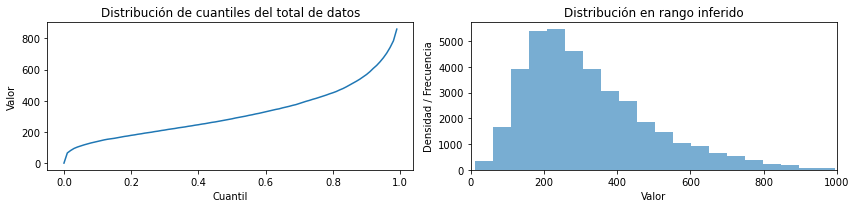

 Distribución                       | Inferencia                                                       
 -----------------------------------+------------------------------------------------------------------
 N° Observaciones :          38,540 | Unidad de medida inferida     : Milígramos por decilitros (mg/dL)
 Mínimo           :            0.00 | Rango                         :                         ]0, 1000[
 Media            :          323.61 | N° Obs. incluidas             :                  38,444 (99.751%)
 Mediana          :          284.00 | Excluidos por límite inferior :                        1 (0.003%)
 Máximo           :        1,534.00 | Excluidos por límite superior :                       95 (0.246%)
 Percentil 01     :           65.00 |
 Percentil 05     :          110.00 |
 Percentil 95     :          675.00 |
 Percentil 99     :          859.00 |


In [226]:
plot_results(var, 'Milígramos por decilitros (mg/dL)', 0, 1000, (0, 0))

## Hemoglobina

In [227]:
query = f'''select labresult as var from lab where labname = 'Hgb' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

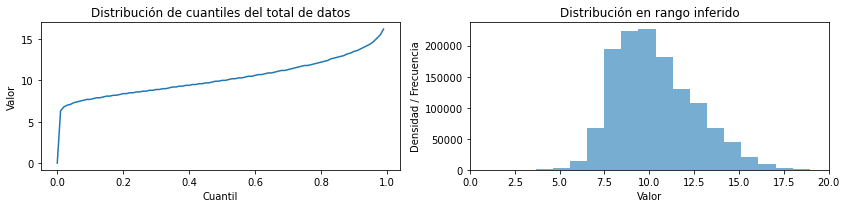

 Distribución                       | Inferencia                                                 
 -----------------------------------+------------------------------------------------------------
 N° Observaciones :       1,298,443 | Unidad de medida inferida     : Gramos por decilitro (g/dL)
 Mínimo           :            0.00 | Rango                         :                     ]0, 20[
 Media            :           10.31 | N° Obs. incluidas             :         1,298,244 (99.985%)
 Mediana          :           10.00 | Excluidos por límite inferior :                  1 (0.000%)
 Máximo           :           96.00 | Excluidos por límite superior :                198 (0.015%)
 Percentil 01     :            6.30 |
 Percentil 05     :            7.30 |
 Percentil 95     :           14.40 |
 Percentil 99     :           16.20 |


In [229]:
plot_results(var, 'Gramos por decilitro (g/dL)', 0, 20, (0, 0))

## Lactate

In [230]:
query = f'''select labresult as var from lab where labname = 'lactate' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

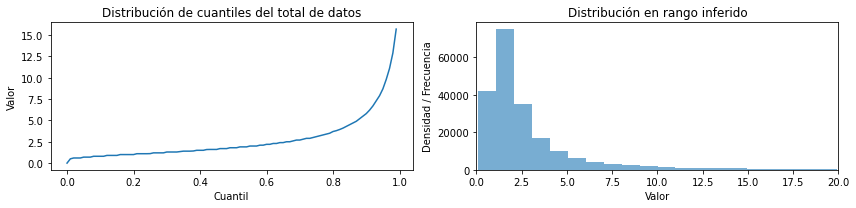

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :         204,602 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.00 | Rango                         :                          ]0, 20[
 Media            :            2.79 | N° Obs. incluidas             :                203,855 (99.635%)
 Mediana          :            1.80 | Excluidos por límite inferior :                       5 (0.002%)
 Máximo           :           41.30 | Excluidos por límite superior :                     742 (0.363%)
 Percentil 01     :            0.50 |
 Percentil 05     :            0.70 |
 Percentil 95     :            8.70 |
 Percentil 99     :           15.70 |


In [231]:
plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 20, (0, 0))

## Magnesium

In [232]:
query = f'''select labresult as var from lab where labname = 'magnesium' and labresult is not null'''
var = pd.read_sql(query, eicu)['var']

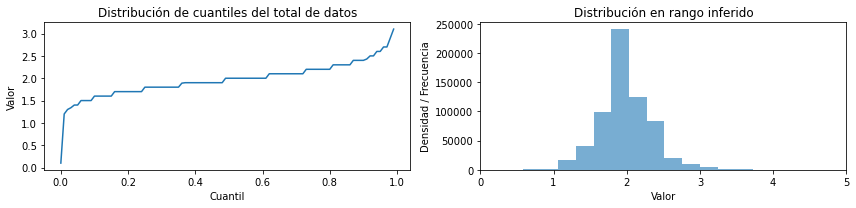

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :         648,578 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :            0.10 | Rango                         :                             ]0, 5[
 Media            :            1.99 | N° Obs. incluidas             :                  647,999 (99.911%)
 Mediana          :            2.00 | Excluidos por límite inferior :                         0 (0.000%)
 Máximo           :           41.30 | Excluidos por límite superior :                       579 (0.089%)
 Percentil 01     :            1.20 |
 Percentil 05     :            1.40 |
 Percentil 95     :            2.60 |
 Percentil 99     :            3.10 |


In [235]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 0, 5, (0, 0))